---
title: Logistic and Bayesian Binomial Models
subject: Methods
subtitle: Facility-level SSI risk modeling without partial pooling
exports: 
  - format: pdf
    template: curvenote
    # template: arxiv_two_column # requires abstract
  # - format: pdf+tex
keywords: [logistic regression, Bayesian binomial model, surgical site infection, hospital performance, facility-level risk, statistical modeling, healthcare quality]
---

In [1]:
#| load-data
library(arrow)
library(rjags)

# Load data
colon_fac_ach <- read_parquet("data/colon_fac_ach.parquet")

Warning message:
“package ‘arrow’ was built under R version 4.5.2”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



## Binomial logistic regression

Below, a standard logistic regression model is fit to the data. `Community, <125 Beds` facilities are used for the reference group.

In [2]:
#| label: lr_fit
# Binomial logistic regression
lr_fit <- glm(cbind(Infections_Reported, No_Infections) ~ Facility_Type,
              data = colon_fac_ach, family = binomial)

summary(lr_fit)


Call:
glm(formula = cbind(Infections_Reported, No_Infections) ~ Facility_Type, 
    family = binomial, data = colon_fac_ach)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           -4.3979     0.2012 -21.856  < 2e-16 ***
Facility_TypeCommunity, >250 Beds      0.6069     0.2194   2.767  0.00566 ** 
Facility_TypeCommunity, 125-250 Beds   0.4526     0.2326   1.946  0.05165 .  
Facility_TypeMajor Teaching            0.6122     0.2076   2.949  0.00318 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 495.24  on 287  degrees of freedom
Residual deviance: 483.68  on 284  degrees of freedom
AIC: 977.75

Number of Fisher Scoring iterations: 5


The standard logistic regression with facility type as the only factor with 4 levels produces only 4 predicted probabilities, which does not adequately explain the large variation observed across individual facilities. This model treats all facilities of the same type identically, ignoring facility volume and county-level effects.

## Bayesian binomial model

The Bayesian binomial model is fit next. Weakly informative $\text{N}(0, 5^2)$ priors are used for the parameters.

$$
\begin{aligned}
y_i \mid \phi_i &\sim \text{Binomial}(n_i, \phi_i), \quad i = 1, \dots, 288 \\
\text{logit}(\phi_i) &= \beta_0 + \beta_1 \cdot \text{beds}_{125\text{-}250,i} + 
                        \beta_2 \cdot \text{beds}_{>250,i} + 
                        \beta_3 \cdot \text{major\_teach}_i \\
\beta_j &\sim \text{Normal}(0, 5^2), \quad j = 0,1,2,3
\end{aligned}
$$

### JAGS model syntax

In [3]:
## Non-hierarchical Bayesian binomial model

# Transform data for JAGS; use Community, <125 Beds for reference level
data_jags_nh <- list(
  y = colon_fac_ach$Infections_Reported,
  n = colon_fac_ach$Procedure_Count,
  beds_125to250 = 
    as.numeric(colon_fac_ach$Facility_Type == 'Community, 125-250 Beds'),
  beds_gt250 = 
    as.numeric(colon_fac_ach$Facility_Type == 'Community, >250 Beds'),
  major_teach = as.numeric(colon_fac_ach$Facility_Type == 'Major Teaching'),
  N = nrow(colon_fac_ach),
  J = 3  # number of predictors
)

# Model syntax
mod_string_nh <- " model {
  # likelihood
  for (i in 1:N) {
    y[i] ~ dbin(p[i], n[i])
    logit(p[i]) <- b0 + b[1]*beds_125to250[i] + b[2]*beds_gt250[i] + 
                        b[3]*major_teach[i]
  }

  # priors
  b0 ~ dnorm(0, 1.0/5^2)
  for (j in 1:J) {
    b[j] ~ dnorm(0.0, 1.0/5^2)  # weakly informative priors (sd ~5)
  }
} "

# Model setup
set.seed(530)

# Define seeds for JAGS chains
jags_seeds <- list(
  list(.RNG.name = "base::Wichmann-Hill", .RNG.seed = 530),
  list(.RNG.name = "base::Wichmann-Hill", .RNG.seed = 531),
  list(.RNG.name = "base::Wichmann-Hill", .RNG.seed = 532)
)

mod_nh <- jags.model(textConnection(mod_string_nh),
                     data = data_jags_nh,
                     inits = jags_seeds,
                     n.chains = 3)

update(mod_nh, 1e4)  # burn-in

params_nh <- c("b0", "b")

# Run model
mod_sim_nh <- coda.samples(mod_nh, variable.names = params_nh, n.iter = 1e5)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 288
   Unobserved stochastic nodes: 4
   Total graph size: 1466

Initializing model



### Diagnostics

#### Trace plots

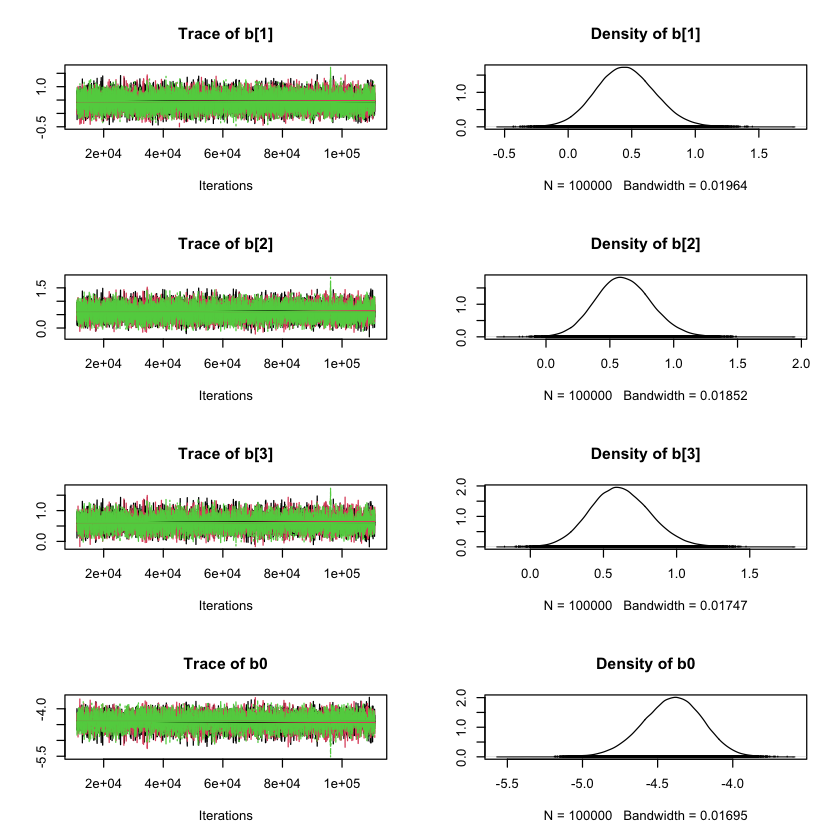

In [4]:
plot(mod_sim_nh)

The chains exhibit autocorrelation, particularly for the intercept, but show good mixing around a stable posterior mean, with no evidence of non-convergence.

#### Autocorrelation

An autocorrelation table and plots for the second chain are shown below.

In [5]:
# Autocorrelation table and plots
autocorr.diag(mod_sim_nh)

,b[1],b[2],b[3],b0
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000
Lag 1,0.8018080,0.8756193,0.9530414,0.9685027
Lag 5,0.6751382,0.7624967,0.8548588,0.8732019
Lag 10,0.5934363,0.6689140,0.7505675,0.7667120
Lag 50,0.2172358,0.2439696,0.2730837,0.2788079


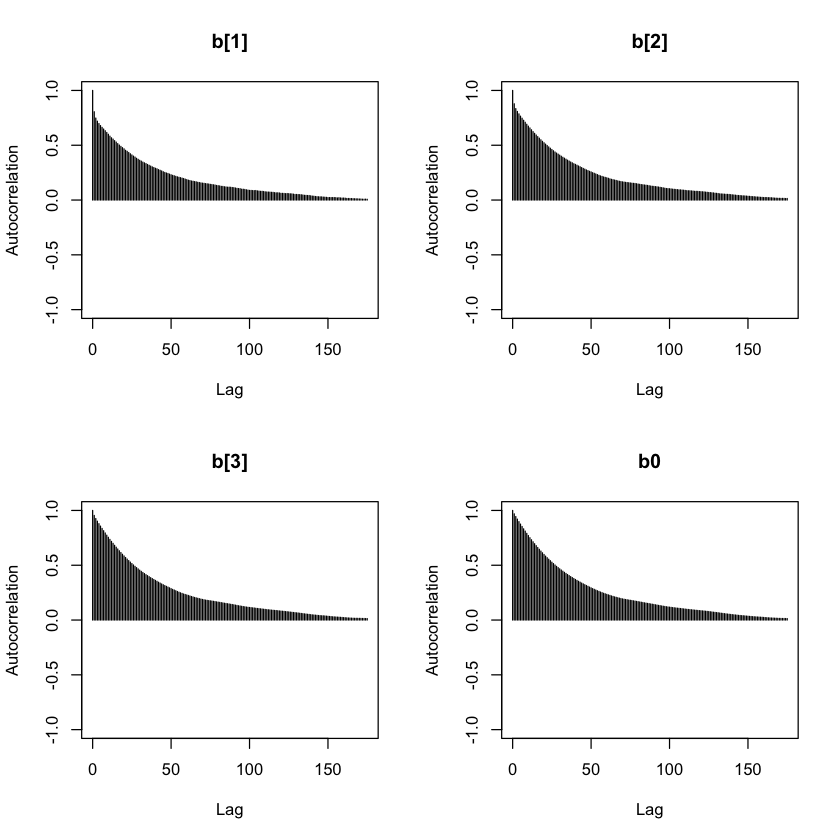

In [6]:
autocorr.plot(mod_sim_nh[[2]], lag.max = 175)

The MCMC chains exhibit high autocorrelation at short lags (lag-1 correlations 0.80–0.97), which gradually decreases at longer lags (lag-50 correlations 0.22–0.28), with good mixing achieved after approximately 150–200 iterations.

#### Gelman-Rubin

The Gelman-Rubin convergence diagnostic is shown below.

In [7]:
gelman.diag(mod_sim_nh)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1       1.00
b[2]          1       1.01
b[3]          1       1.01
b0            1       1.01

Multivariate psrf

1

Convergence diagnostics indicated good mixing across chains. All Gelman-Rubin PSRF values are equal to 1 (both univariate and multivariate), suggesting that between-chain and within-chain variances were indistinguishable and that the MCMC chains had converged to a common posterior distribution.

#### Effective sample sizes

Effective sample sizes are shown below.

In [8]:
round(effectiveSize(mod_sim_nh), 1)

b[1]   b[2]   b[3]     b0 
5118.1 4502.0 4001.7 3887.5

Despite high autocorrelation in the MCMC chains, the effective sample sizes for all parameters are high, indicating that the posterior estimates are based on several thousand independent-equivalent draws. This provides confidence in the accuracy and stability of the posterior summaries.

#### Raftery-Lewis diagnostics

Raftery-Lewis diagnostics for the second chain are shown below.

In [9]:
raftery.diag(mod_sim_nh[[2]])


Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 65       65871  3746         17.6      
 b[2] 78       81601  3746         21.8      
 b[3] 84       95496  3746         25.5      
 b0   100      106720 3746         28.5      


Raftery-Lewis diagnostics indicate that the MCMC chains are moderately autocorrelated, particularly for the intercept (b0), with dependence factors up to 29. Recommended total iterations to estimate the 0.025 quantile to ±0.005 accuracy are 65,000–110,000 depending on the parameter. Given that 90,000 iterations were run after burn-in, the chains provide sufficient information for posterior summaries, although extreme quantiles of the intercept may be slightly less precise.

### Deviance information criterion (DIC)

The DIC statistic for the model is shown below.

In [10]:
(dic_nh <- dic.samples(mod_nh, n.iter = 1e3))

Mean deviance:  973.9 
penalty 4.364 
Penalized deviance: 978.3 

For the current Bayesian binomial model, the mean deviance is 973.9 with a small effective number of parameters (4.36), resulting in a penalized deviance (DIC) of 978.3. This serves as a baseline for comparison with more complex models, such as the hierarchical model.

### Model summary

The results of the fitted model are shown below.

In [11]:
#| label: nh_fit
summary(mod_sim_nh)


Iterations = 11001:111000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD  Naive SE Time-series SE
b[1]  0.4508 0.2308 0.0004214       0.003227
b[2]  0.6079 0.2176 0.0003974       0.003244
b[3]  0.6157 0.2053 0.0003749       0.003247
b0   -4.4027 0.1993 0.0003638       0.003197

2. Quantiles for each variable:

         2.5%     25%     50%     75%  97.5%
b[1]  0.01073  0.2933  0.4462  0.6031  0.916
b[2]  0.19739  0.4588  0.6020  0.7512  1.050
b[3]  0.23016  0.4746  0.6091  0.7509  1.034
b0   -4.81178 -4.5330 -4.3958 -4.2655 -4.031


Compared with the reference group, all three groups have higher estimated probabilities of the outcome. On the log-odds scale, the posterior means are 0.45, 0.61, and 0.62 for groups 1–3, with 95% credible intervals largely above zero, suggesting that all groups are likely to differ from the reference group. These results are closely aligned with the binomial logistic regression results.